# NIRSpec NRS2 Wavelength Calibration Example

**Author:** Hannu Parviainen </br>
**Edited:** 2025-07-31 

In [1]:
import warnings

import numpy as np
import pandas as pd

from astropy.nddata import CCDData, StdDevUncertainty, VarianceUncertainty
from astropy.visualization import simple_norm
from astropy.modeling.models import Polynomial1D

import matplotlib.pyplot as plt 
import matplotlib.patheffects as path_effects
import astropy.units as u

from specreduce.tracing import FitTrace
from specreduce.background import Background
from specreduce.extract import HorneExtract, BoxcarExtract
from specreduce.wavecal1d import WavelengthCalibration1D

fheight = 3.5
fwidth = 14

plt.rcParams['figure.figsize'] = (fwidth, fheight)
plt.rcParams['figure.constrained_layout.use'] = True

def plot_spectrum(image, min_percent: float = 50.0, max_percent: float = 99.9):
    fig, ax = plt.subplots()
    n = simple_norm(image, stretch='log', min_percent=min_percent, max_percent=max_percent)
    ax.imshow(image, aspect='auto', norm=n, interpolation='nearest', origin='lower')
    ax.autoscale(axis='x', tight=True)
    return fig

## Read the Frame

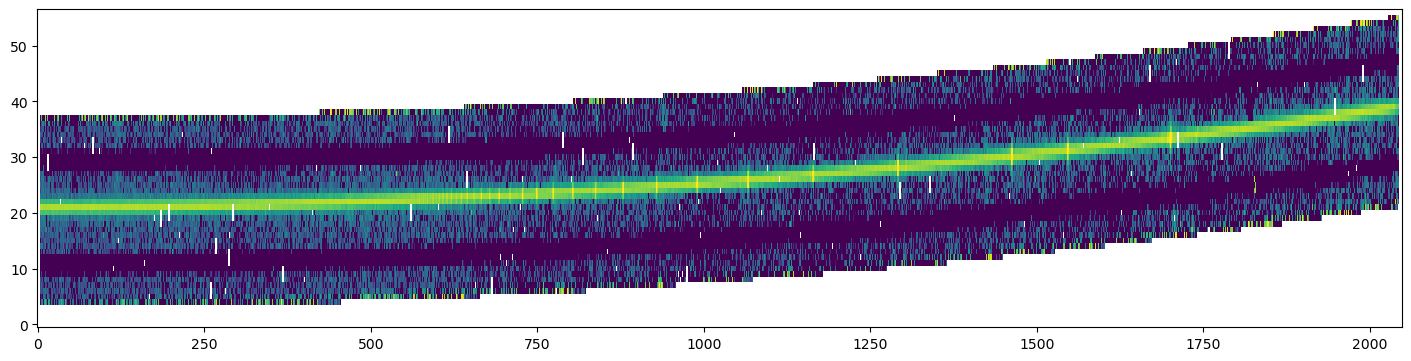

In [3]:
fname = 'jw01125001001_0310c_00004_nrs2_cal.fits'

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    img = CCDData.read(fname, 1)
    img.data = img.data.astype('d')
    img.uncertainty = StdDevUncertainty(np.full(img.data.shape, np.nanstd(np.diff(img.data, axis=0)) / np.sqrt(2)))
    plot_spectrum(img);

## Trace the spectrum

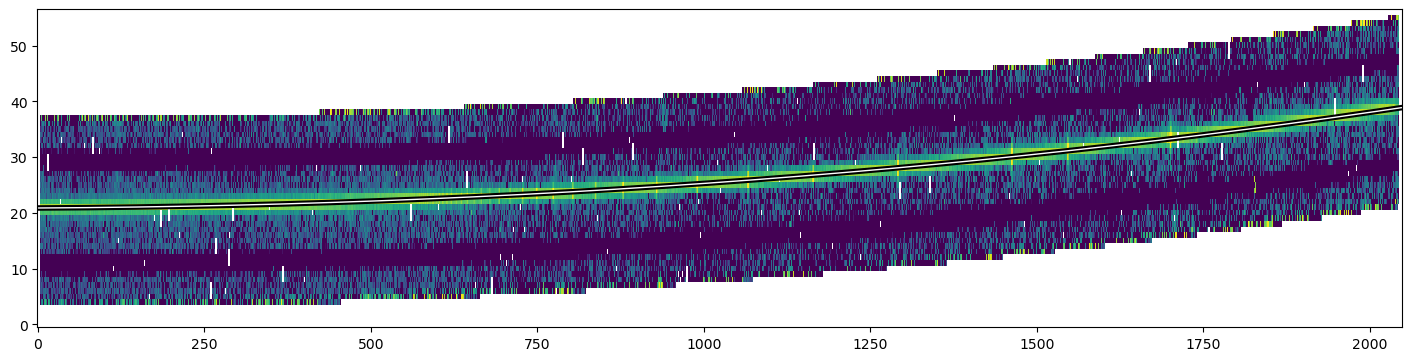

In [4]:
trace = FitTrace(img, guess=25, bins=20, trace_model=Polynomial1D(3))

fig = plot_spectrum(img)
fig.axes[0].plot(trace.trace, 'w', lw=1, path_effects=[path_effects.Stroke(linewidth=4, foreground='k'),path_effects.Normal()]);

## Extract the Spectrum

In [5]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    spectrum = BoxcarExtract(img, trace, width=5).spectrum
    spectrum.uncertainty = StdDevUncertainty(np.full_like(spectrum.flux.value, np.nanstd(np.diff(spectrum.flux.value)) / np.sqrt(2)))

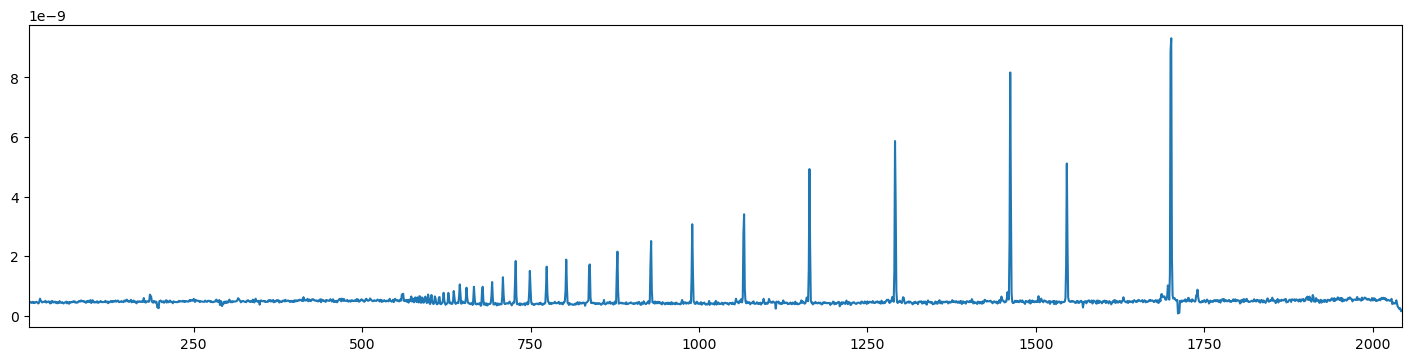

In [6]:
fig, ax = plt.subplots()
ax.plot(spectrum.flux.value)
ax.autoscale(axis='x', tight=True);

## Wavelength calibration

In [7]:
cal_lines = pd.read_csv('H-Paschen-Brackett.csv').values[:, 1].astype('d')

wc = WavelengthCalibration1D(1000, unit=u.micron, degree=3, arc_spectra=spectrum, line_lists=cal_lines, line_list_bounds=(1.3, 1.8))

Next, we find the lines in the arc frame and use the `WavelengthCalibration1D.plot_fit` method to plot both the catalog lines and the observed lines. Since we haven't calculated a wavelength solution yet, the catalog lines are shown in their native units and the observed lines in pixels.

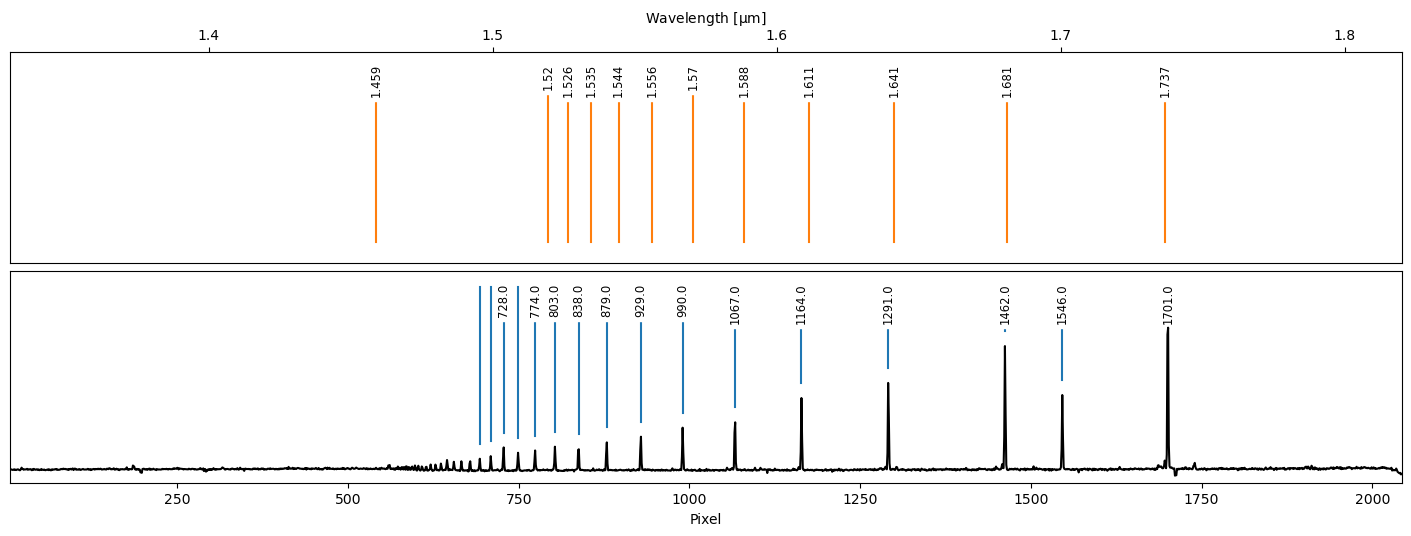

In [8]:
wc.find_lines(fwhm=5, noise_factor=4)

fig = wc.plot_fit(figsize=(fwidth, 1.5*fheight))
plt.setp(fig.axes[0], xlim=(1.33, 1.82));

### Option 1: Interactive Fit

We can use the `WavelengthCalibration1D.fit_lines` to fit the model to a set of manually matched lines, and plot the fit setting `obs_to_wav=True` to map the observed lines and the arc spectrum to wavelength space. We also set `refine_fit=True`, which makes the fitting routine match the observed and catalog lines based on the first fit, and then refines the fit by fitting all the matching lines (instead of only the lines given to the method).

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    wc.fit_lines(pixels=[1067, 1462, 1701], wavelengths=[1.589, 1.681, 1.7367], refine_fit=True)

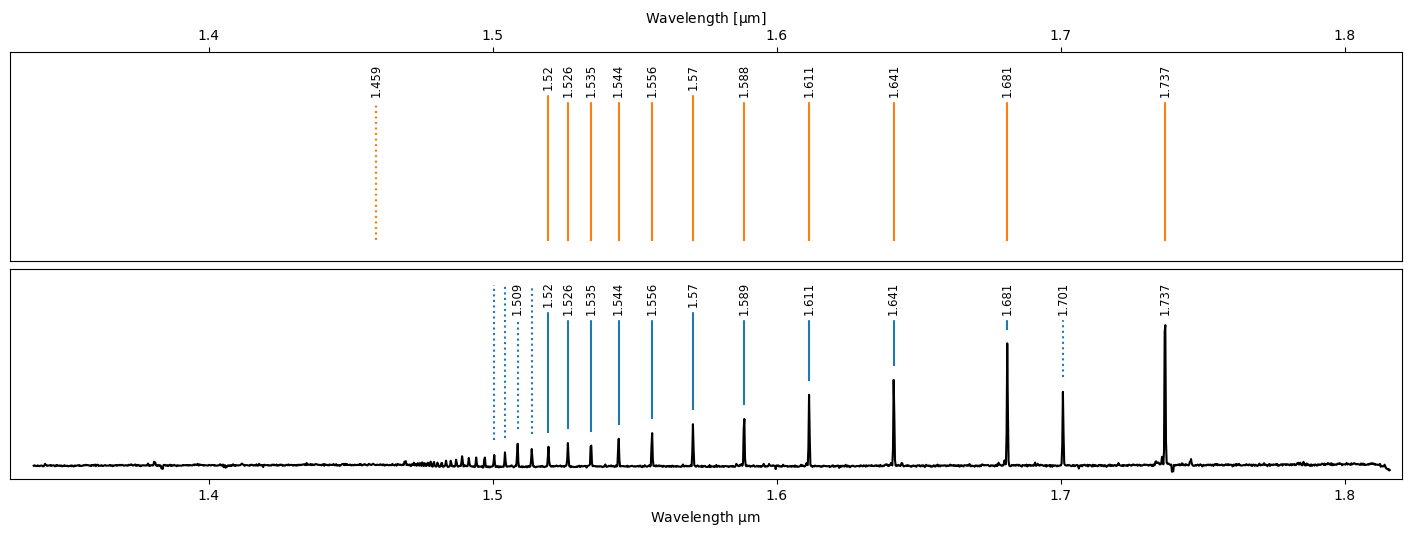

In [10]:
fig = wc.plot_fit(obs_to_wav=True, figsize=(fwidth, 1.5*fheight))
plt.setp(fig.axes, xlim=(1.33, 1.82));

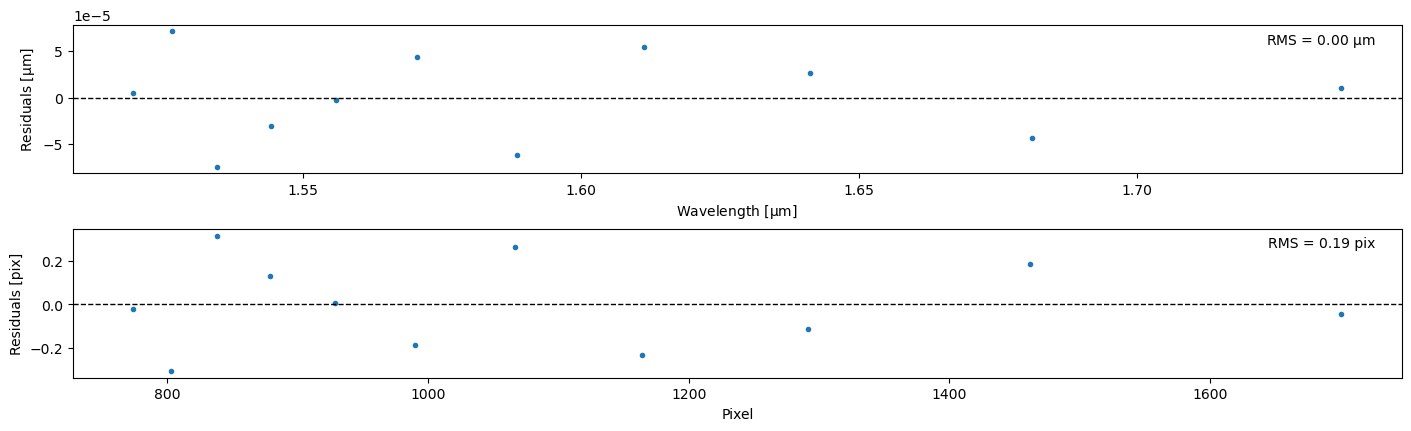

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(fwidth, 1.2*fheight))
wc.plot_residuals(space='wavelength', ax=axs[0])
wc.plot_residuals(space='pixel', ax=axs[1]);

### Option 2: Non-interactive Fit

`WavelengthCalibration1D` also supports a non-interactive workflow that is especially suitable for automatic pipelines for relatively stable instruments. The  `WavelengthCalibration1D.fit_global` method can be used to fit a wavelength solution given the wavelength and dispersion bounds at the reference pixel. The method ses a global optimizer to fit a wavelength solution without the need to select a set of matching pixel and wavelength pairs.

In [12]:
wc.fit_global(wavelength_bounds=[1.55, 1.58], dispersion_bounds=[0.00023, 0.00024], refine_fit=True)

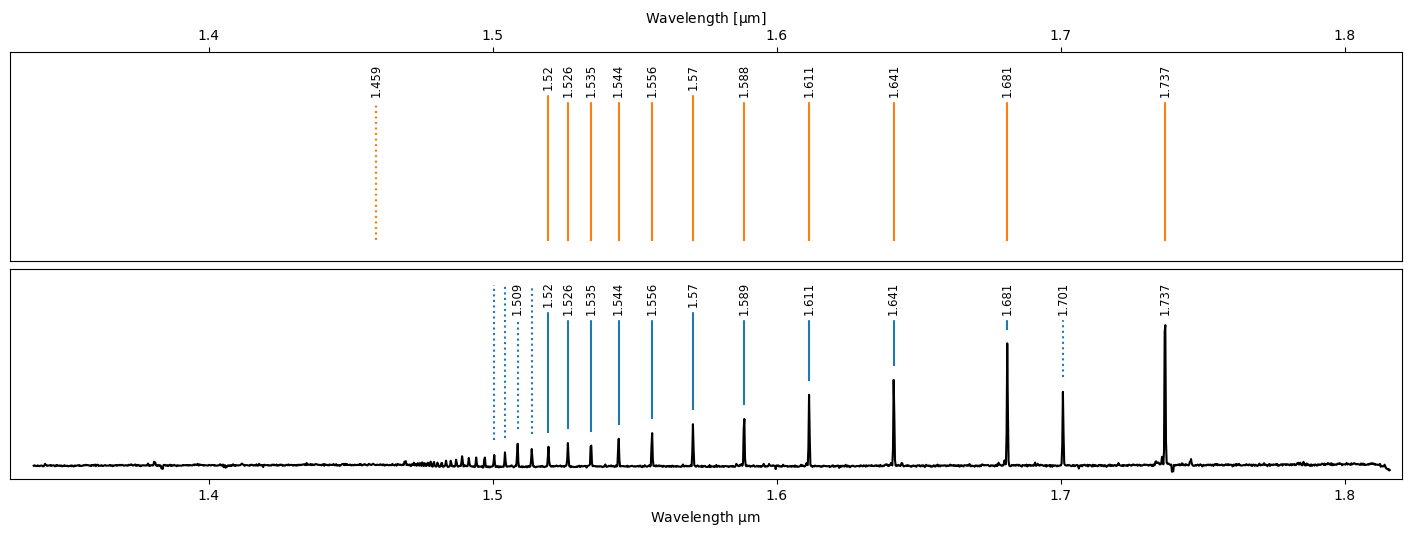

In [13]:
fig = wc.plot_fit(obs_to_wav=True, figsize=(fwidth, 1.5*fheight))
plt.setp(fig.axes, xlim=(1.33, 1.82));

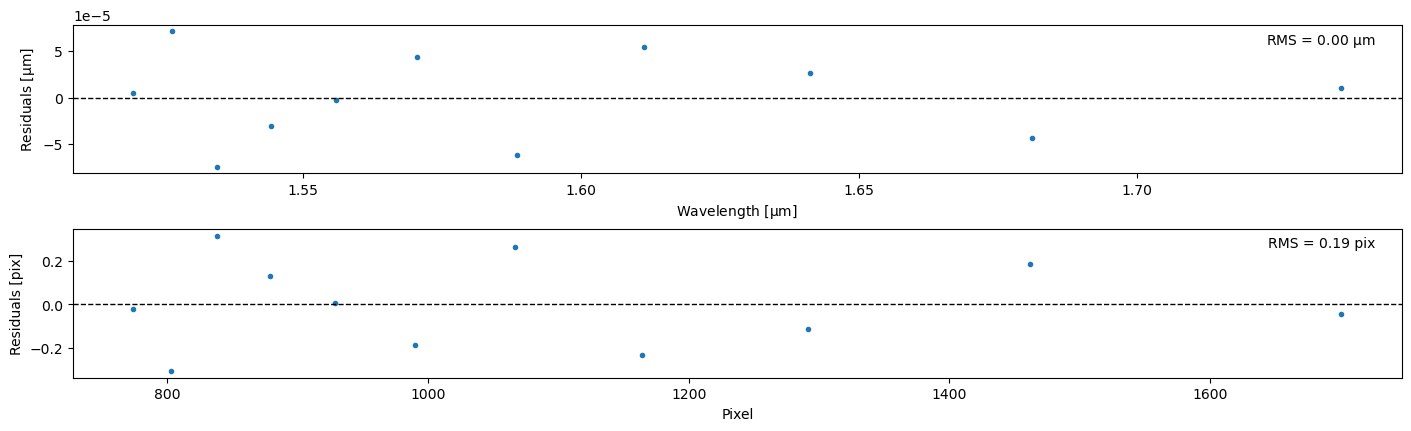

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(fwidth, 1.2*fheight))
wc.plot_residuals(space='wavelength', ax=axs[0])
wc.plot_residuals(space='pixel', ax=axs[1]);

## Resample the Spectrum to a Linear Wavelength Grid

In [27]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    calibrated_spectrum = wc.resample(spectrum, wlbounds=(1.33, 1.82))

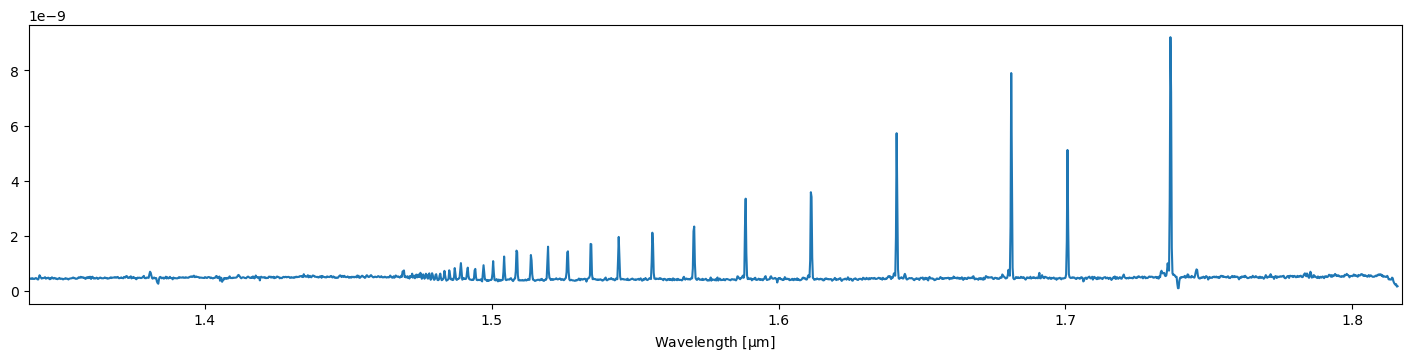

In [64]:
fig, ax = plt.subplots()
ax.plot(calibrated_spectrum.wavelength, calibrated_spectrum.flux.value)
ax.autoscale(axis='x', tight=True)
plt.setp(fig.axes, xlabel=f'Wavelength [{wc._unit_str}]');